### Figure 7 (Warmup+All)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import math
import numpy as np
import matplotlib.pyplot as plt
from math import log, e
import torch.optim as optim
import pickle
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
plt.rcParams.update({'font.size': 20, 'figure.figsize': (8,4.5), 'font.family':'Arial', 'axes.axisbelow':True})

torch.manual_seed(22)
np.random.seed(22)

DIR_NAME = 'warmup+all/'
SAVE=True
GROUP_SIZE=0.98
NOISE=1/8

In [2]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, small=True):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, out_channel*2, int(input_dim/patch_num), int(input_dim/patch_num))        
        if small:
            self.conv1.weight = torch.nn.Parameter(self.conv1.weight*0.1) 
            self.conv1.bias = torch.nn.Parameter(self.conv1.bias*0.1) 
        self.out_channel = out_channel

    def forward(self, x):
        x = self.conv1(x)
        x = x**3
        x = torch.sum(x,2)
        output = torch.stack([torch.sum(x[:,:self.out_channel],1), torch.sum(x[:,self.out_channel:],1)]).transpose(1,0)
        return output

In [3]:
def train(model, criterion, data, labels, optimizers, epochs=100, plot=False, verbose=True):
    min_loss = 100
    core, spu, loss_list = [], [], []
    core_inner, spu_inner = test_inner(model)
    core.append(core_inner)
    spu.append(spu_inner)

    for epoch in range(epochs):  
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels) 
        loss_list.append(loss.detach())
        loss.backward() 
        core_inner, spu_inner = test_inner(model)
        core.append(core_inner)
        spu.append(spu_inner)

        for optimizer in optimizers:
            optimizer.step()
        
        if epoch%100 == 0:
            if verbose:
                print('Epoch %d --- loss: %.3f' % (epoch + 1, loss.item()))
    
    core, spu, loss_list = torch.stack(core), torch.stack(spu), torch.stack(loss_list)
    print('Finished Training')
    return core, spu, loss_list


def test(model, criterion, data, labels):
    correct = 0
    with torch.no_grad():
        outputs = model(data) 
        predicted = torch.max(outputs.data, 1).indices
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %.4f %%' % (data.shape[0],
        100 * correct / data.shape[0]))
    
    return 100 * correct / data.shape[0]


def test_inner(model):
    with torch.no_grad():
        core_inner = torch.max(torch.abs(torch.matmul(model.conv1.weight.squeeze(1), 
                                                      vc.float().unsqueeze(1).cuda())))
        spurious_inner = torch.max(torch.abs(torch.matmul(model.conv1.weight.squeeze(1), 
                                                          vs.float().unsqueeze(1).cuda())))
        
    return core_inner, spurious_inner

In [4]:
DATA_NUM = 10000
PATCH_NUM = 3
PATCH_LEN = 50

def div_norm(x):
    x /= np.linalg.norm(x)
    return x

vc = np.random.randn(PATCH_LEN) 
vc /= np.linalg.norm(vc)

vs = np.random.randn(PATCH_LEN) 
vs /= np.linalg.norm(vs)
vs -= vs.dot(vc) * vc
vs /= np.linalg.norm(vs)

vc, vs = torch.tensor(vc), torch.tensor(vs)

data = []
data_visual = []
labels = []
spurious_labels = []

xi_large, xi_small = torch.zeros(PATCH_LEN), torch.zeros(PATCH_LEN)

for i in range(DATA_NUM*2):
    y = np.random.choice([-1,1], 1)[0] 
    alpha = np.random.uniform(0,1)

    # Feature noise patch
    a = (alpha<GROUP_SIZE)*y - (alpha>=GROUP_SIZE)*y
    # Noise patch
    xi = torch.tensor(np.random.normal(0, NOISE, size=(PATCH_LEN)))
    
    if a==y:
        xi_large+=xi
    else:
        xi_small+=xi

    core = vc*y/5 
    spurious = vs*a
    x = torch.stack([core, spurious, xi])
    
    x_visual = torch.stack([core*1.2, spurious, xi])
    
    x = x.flatten()
    x_visual = x_visual.flatten()

    data.append(x)
    data_visual.append(x_visual)
    labels.append(y)
    spurious_labels.append(a)

data = torch.stack(data)
data_visual = torch.stack(data_visual)
print(data.shape)

labels = torch.tensor(labels)
spurious_labels = torch.tensor(spurious_labels)
labels[labels==-1] = 0
spurious_labels[spurious_labels==-1]=0
print(labels.shape)

training_data = data[:DATA_NUM,:].unsqueeze(1).float().cuda()
test_data = data[DATA_NUM:,:].unsqueeze(1).float().cuda()

print(training_data.shape, test_data.shape)

training_labels = labels[:DATA_NUM].cuda()
test_labels = labels[DATA_NUM:].cuda()
spurious_training_labels = spurious_labels[:DATA_NUM].cuda()
spurious_test_labels = spurious_labels[DATA_NUM:].cuda()
print(training_labels.shape, test_labels.shape)

training_labels = training_labels.long()
test_labels = test_labels.long()
spurious_training_labels = spurious_training_labels.long()
spurious_test_labels = spurious_test_labels.long()

torch.Size([20000, 150])
torch.Size([20000])
torch.Size([10000, 1, 150]) torch.Size([10000, 1, 150])
torch.Size([10000]) torch.Size([10000])


In [5]:
pca = TSNE(n_components=2)

data_visual= pca.fit_transform(data_visual.float().cpu())
data_visual = data_visual/np.max(np.abs(data_visual))

visual_data_train = data_visual[:DATA_NUM,:]
visual_data_test = data_visual[DATA_NUM:,:]

/home/yihe/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/yihe/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [6]:
for i in range(DATA_NUM):
    idx = torch.randperm(PATCH_NUM)
    stack_data = torch.stack([training_data[i,0,:][j*PATCH_LEN:(j+1)*PATCH_LEN] for j in range(PATCH_NUM)])
    stack_data = stack_data[idx].flatten()
    training_data[i,0,:] = stack_data

    idx = torch.randperm(PATCH_NUM)
    stack_data = torch.stack([test_data[i,0,:][j*PATCH_LEN:(j+1)*PATCH_LEN] for j in range(PATCH_NUM)])
    stack_data = stack_data[idx].flatten()
    test_data[i,0,:] = stack_data

In [7]:
small_test_data = torch.concat([test_data[[x and y for x,y in zip(test_labels==1,spurious_test_labels==0)]],test_data[[x and y for x,y in zip(test_labels==0,spurious_test_labels==1)]]])
small_test_label = torch.concat([test_labels[[x and y for x,y in zip(test_labels==1,spurious_test_labels==0)]],test_labels[[x and y for x,y in zip(test_labels==0,spurious_test_labels==1)]]])

In [8]:
smallest_group_size = min(len(training_data[[x and y for x,y in zip(training_labels==0,spurious_training_labels==1)]]),len(training_data[[x and y for x,y in zip(training_labels==1,spurious_training_labels==0)]]))

In [9]:
warmup_data = []
warmup_data.append(training_data[[x and y for x,y in zip(training_labels==0,spurious_training_labels==0)]][:smallest_group_size])
warmup_data.append(training_data[[x and y for x,y in zip(training_labels==1,spurious_training_labels==0)]][:smallest_group_size])
warmup_data.append(training_data[[x and y for x,y in zip(training_labels==0,spurious_training_labels==1)]][:smallest_group_size])
warmup_data.append(training_data[[x and y for x,y in zip(training_labels==1,spurious_training_labels==1)]][:smallest_group_size])
warmup_data = torch.concat(warmup_data)

warmup_data.shape

torch.Size([424, 1, 150])

In [10]:
warmup_labels = []
warmup_labels.append(training_labels[[x and y for x,y in zip(training_labels==0,spurious_training_labels==0)]][:smallest_group_size])
warmup_labels.append(training_labels[[x and y for x,y in zip(training_labels==1,spurious_training_labels==0)]][:smallest_group_size])
warmup_labels.append(training_labels[[x and y for x,y in zip(training_labels==0,spurious_training_labels==1)]][:smallest_group_size])
warmup_labels.append(training_labels[[x and y for x,y in zip(training_labels==1,spurious_training_labels==1)]][:smallest_group_size])
warmup_labels = torch.concat(warmup_labels)

warmup_labels.shape

torch.Size([424])

In [11]:
CNN = ConvNet(PATCH_LEN*PATCH_NUM, 20, PATCH_NUM).cuda() 
pred = CNN(test_data)
criterion = torch.nn.CrossEntropyLoss()
test(CNN, criterion, test_data, test_labels)

num_epochs = 801
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(CNN.parameters(), lr=0.03, momentum=0.9)

core, spu, loss_list = train(CNN, criterion, warmup_data, warmup_labels, [optimizer], num_epochs, plot=False)
test(CNN, criterion, test_data, test_labels)
test(CNN, criterion, small_test_data, small_test_label)

Accuracy of the network on the 10000 test images: 72.3800 %
Epoch 1 --- loss: 0.693
Epoch 101 --- loss: 0.693
Epoch 201 --- loss: 0.693
Epoch 301 --- loss: 0.693
Epoch 401 --- loss: 0.693
Epoch 501 --- loss: 0.693
Epoch 601 --- loss: 0.692
Epoch 701 --- loss: 0.662
Epoch 801 --- loss: 0.108
Finished Training
Accuracy of the network on the 10000 test images: 92.5500 %
Accuracy of the network on the 229 test images: 94.7598 %


94.75982532751091

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


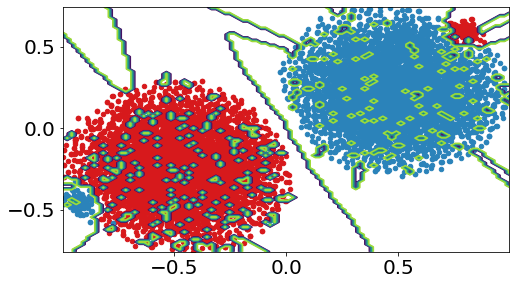

In [12]:
pred = CNN(test_data)

resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(visual_data_test[:,0]), np.max(visual_data_test[:,0])
X2d_ymin, X2d_ymax = np.min(visual_data_test[:,1]), np.max(visual_data_test[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(visual_data_test, torch.max(pred.data, 1).indices.cpu().numpy()) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.scatter(visual_data_test[test_labels.cpu()==0][:,0],visual_data_test[test_labels.cpu()==0][:,1], s=20, marker='o',color='#d7191c')
plt.scatter(visual_data_test[test_labels.cpu()==1][:,0],visual_data_test[test_labels.cpu()==1][:,1], s=20, marker='o',color='#2b83ba')
plt.contour(xx, yy, voronoiBackground)

if SAVE:
    plt.savefig(DIR_NAME+"synthetic_dbtest0.pdf")

Epoch 1 --- loss: 0.209
Epoch 101 --- loss: 0.036
Epoch 201 --- loss: 0.033
Epoch 301 --- loss: 0.032
Epoch 401 --- loss: 0.031
Epoch 501 --- loss: 0.031
Epoch 601 --- loss: 0.031
Epoch 701 --- loss: 0.030
Finished Training
Accuracy of the network on the 10000 test images: 99.0000 %
Accuracy of the network on the 229 test images: 74.2358 %


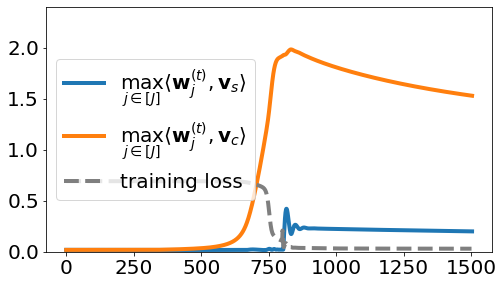

In [13]:
num_epochs = 701
plt.rcParams.update({'figure.figsize': (8,4.5)})

core1, spu1, loss_list1 = train(CNN, criterion, training_data, training_labels, [optimizer], num_epochs, plot=False)
test(CNN, criterion, test_data, test_labels)
test(CNN, criterion, small_test_data, small_test_label)

core = torch.concat([core,core1])
spu = torch.concat([spu,spu1])
loss_list = torch.concat([loss_list,loss_list1])

plt.plot(spu.cpu(),linewidth=4,color="tab:blue",label=r'$\max_{j\in[J]}\langle\mathbf{w}_j^{(t)},\mathbf{v}_s\rangle$')
plt.plot(core.cpu(),linewidth=4,color="tab:orange",label=r'$\max_{j\in[J]}\langle\mathbf{w}_j^{(t)},\mathbf{v}_c\rangle$')
plt.plot(loss_list.cpu(),linewidth=4,color="tab:gray",linestyle='--',label='training loss')
plt.ylim(0,2.4)
plt.legend(prop={'size': 20},loc='center left')

if SAVE:
    plt.savefig(DIR_NAME+"warmup2.pdf")

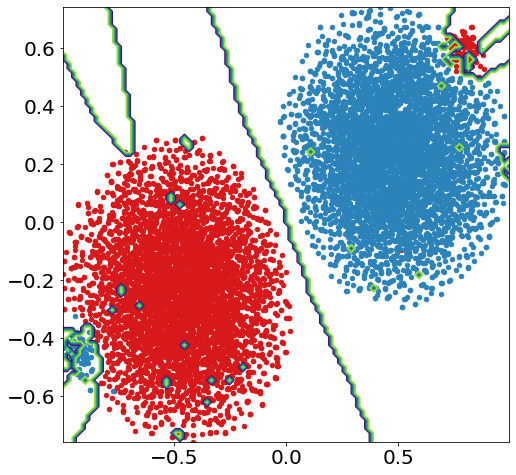

In [14]:
pred = CNN(test_data)

resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(visual_data_test[:,0]), np.max(visual_data_test[:,0])
X2d_ymin, X2d_ymax = np.min(visual_data_test[:,1]), np.max(visual_data_test[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(visual_data_test, torch.max(pred.data, 1).indices.cpu().numpy()) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
plt.rcParams.update({'figure.figsize': (8,8)})
plt.scatter(visual_data_test[test_labels.cpu()==0][:,0],visual_data_test[test_labels.cpu()==0][:,1], s=20, marker='o',color='#d7191c')
plt.scatter(visual_data_test[test_labels.cpu()==1][:,0],visual_data_test[test_labels.cpu()==1][:,1], s=20, marker='o',color='#2b83ba')
plt.contour(xx, yy, voronoiBackground)

if SAVE:
    plt.savefig(DIR_NAME+"synthetic_dbtest1.pdf")

In [15]:
test(CNN, criterion, test_data, test_labels)

Accuracy of the network on the 10000 test images: 99.0000 %


99.0

In [16]:
test(CNN, criterion, test_data[[x and y for x,y in zip(test_labels==1,spurious_test_labels==0)]], test_labels[[x and y for x,y in zip(test_labels==1,spurious_test_labels==0)]])

Accuracy of the network on the 113 test images: 69.9115 %


69.91150442477876

In [17]:
test(CNN, criterion, test_data[[x and y for x,y in zip(test_labels==0,spurious_test_labels==1)]], test_labels[[x and y for x,y in zip(test_labels==0,spurious_test_labels==1)]])

Accuracy of the network on the 116 test images: 78.4483 %


78.44827586206897

In [18]:
test(CNN, criterion, small_test_data, small_test_label)

Accuracy of the network on the 229 test images: 74.2358 %


74.23580786026201